In [1]:
# script to save the rankings for the mechanism
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.colors as mcolors

import matplotlib.pyplot as plt
import matplotlib.patches
%matplotlib inline


In [2]:
# Load the experimental conditions
ignition_delay_data = '/home/moon/autoscience/autoscience/butane/experimental_data/butane_ignition_delay.csv'
df_exp = pd.read_csv(ignition_delay_data)

# slice just table 7, where phi=1.0
table7 = df_exp[df_exp['Table'] == 7]
# Define Initial conditions using experimental data
tau7 = table7['time (ms)'].values.astype(float)  # ignition delay
T7 = table7['T_C'].values  # Temperatures
P7 = table7['nominal pressure(atm)'].values * 101325.0  # pressures in atm

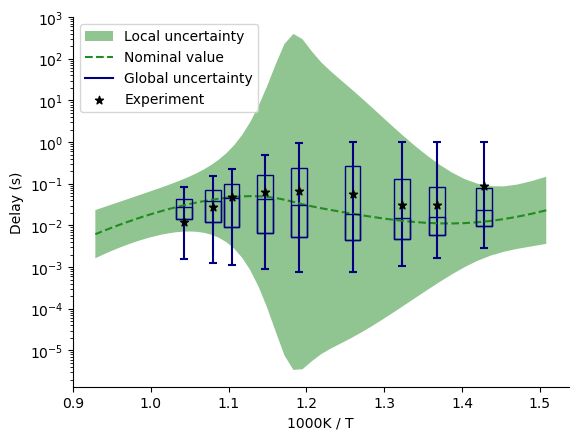

In [5]:
mech_dir = '/home/moon/autoscience/fuels/butane_20240501'

global_color = mcolors.hex2color(mcolors.CSS4_COLORS['navy'])
RMG_min_7_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
alpha = 0.5

# Load the analysis files
analysis_dir = os.path.join(mech_dir, 'analysis')
total_uncertainty_mat = np.load(os.path.join(analysis_dir, 'total_uncertainty_mat.npy'))
dft_uncertainty_mat = np.load(os.path.join(analysis_dir, 'dft_uncertainty_mat.npy'))
first_derivative = np.load(os.path.join(analysis_dir, 'first_derivative.npy'))
improvement_score = np.load(os.path.join(analysis_dir, 'improvement_score.npy'))
base_delay_file = os.path.join(mech_dir, 'total_base_delays.npy')
base_delays = np.load(base_delay_file)

# recompute the total local uncertainty
delta_uncertainty_squared = np.float_power(total_uncertainty_mat, 2.0) - np.float_power(dft_uncertainty_mat, 2.0)
sensitivity_squared = np.float_power(first_derivative, 2.0)
improvement_score = np.multiply(delta_uncertainty_squared, sensitivity_squared)
avg_improvement_score = np.nanmean(improvement_score, axis=1)
avg_improvement_score[np.isnan(avg_improvement_score)] = -np.inf
improvement_score[np.isnan(improvement_score)] = -np.inf
total_uncertainty_squared = np.nansum(np.multiply(sensitivity_squared, np.float_power(total_uncertainty_mat, 2.0)), axis=0)
total_uncertainty = np.array(np.float_power(total_uncertainty_squared, 0.5)).ravel()

# fetch the Table 7 results
Tmax = 1077  # use min and max temperature range of the data: 663K-1077K
Tmin = 663
K = 51  # number of temperature points in the grid
temperatures = np.linspace(Tmin, Tmax, K)
table_index = 7
base_delays7 = base_delays[(table_index - 1) * K: table_index * K]
total_uncertainty7 = np.array(total_uncertainty[(table_index - 1) * K: table_index * K])
upper_bound_stddev = np.exp(np.log(base_delays7) + total_uncertainty7)
lower_bound_stddev = np.exp(np.log(base_delays7) - total_uncertainty7)


# Plot Local Uncertainty
plt.fill_between(1000.0 / temperatures, base_delays7, upper_bound_stddev, alpha=alpha, color=RMG_min_7_color, edgecolor=None, label='Local uncertainty')
plt.fill_between(1000.0 / temperatures, lower_bound_stddev, base_delays7, alpha=alpha, color=RMG_min_7_color, edgecolor=None)

# Plot RMG-min-7, nominal delays
plt.plot(1000.0 / temperatures, base_delays7, color=RMG_min_7_color, label='Nominal value', linestyle='dashed')

# Compile global delay data from files into run_data matrix
Tlist = [700, 731, 756, 794, 840, 872, 906, 926, 959, 1000]
delay_files = glob.glob(os.path.join(mech_dir, 'mc_sampling', 'delays_*.npy'))
M = len(np.load(delay_files[0]))  # M is number of data points per file
run_data = np.zeros((len(delay_files) * M, len(Tlist)))
for f in range(len(delay_files)):
    run_data[f * M: (f + 1) * M, :] = np.load(delay_files[f])
run_data[run_data == 0] = np.nan
run_data[run_data < 0] *= -1

# Grab the experimental ignition delays and put into tau_list
tau_list = []
for i in range(len(T7)):
    if int(T7[i]) in Tlist:
        tau_list.append(tau7[i])

        
# Plot Everything on One acis
ax = plt.gca()
for i in range(len(Tlist[0:-1])):
    
    # Make the box-plots
    x = 1000.0 / Tlist[i]
    y = np.nanpercentile(run_data[:, i], 25)
    w = 20 / 1000
    h = np.nanpercentile(run_data[:, i], 75) - np.nanpercentile(run_data[:, i], 25)
    h2 = np.nanpercentile(run_data[:, i], 50) - np.nanpercentile(run_data[:, i], 25)
    
    r = matplotlib.patches.Rectangle((x - w / 2.0, y), width=w, height=h, color=global_color, fill=None, zorder=9)
    r2 = matplotlib.patches.Rectangle((x - w / 2.0, y), width=w, height=h2, color=global_color, fill=None, zorder=9)
    ax.add_patch(r)
    ax.add_patch(r2)
    
    # plot the whiskers
    plt.vlines(x, np.nanpercentile(run_data[:, i], 2.5), np.nanpercentile(run_data[:, i], 97.5), color=global_color)
    plt.scatter(x, np.nanpercentile(run_data[:, i], 2.5), marker='_', color=global_color, zorder=9)
    plt.scatter(x, np.nanpercentile(run_data[:, i], 97.5), marker='_', color=global_color, zorder=9)
     
# Plot Global Uncertainty
plt.plot(x, y, color=global_color, label='Global uncertainty')

# Plot Experimental Data
plt.scatter(1000.0 / np.array(Tlist[:-1]), np.array(tau_list) / 1000.0, color='black', marker='*', label='Experiment', zorder=10)


ax = plt.gca()
ax.set_yscale('log')

# plt.title('RMG-min-7')
plt.legend()
plt.xlabel('1000K / T')
plt.ylabel(r'Delay (s)')

# rearrange legend order
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 0, 1, 3]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc='upper left')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.set_yticks([1.E-5,1.E-4,1.E-3,1.E-2,1.E-1,1.E0,1.E1,1.E2,1.E3])    
plt.savefig('global_uncertainty.pdf', bbox_inches='tight')